# Trabajo práctico n° 2
## Evolución del salario joven desde el año 2007

Integrantes:
- Mazo, Luis
- Hoj, Agustín
- Nacucchio, Illed

El objetivo de este programa es ofrecer una interfaz gráfica de análisis de la evolución del salario joven desde el 2007 hasta la actualidad y poder predecir cómo seguirá evolucionando en los años inmediatos. Además, permite hacer comparaciones sobre la valoración de cada sector de trabajo entre sí y contra el salario mínimo vital móvil. Para ello se cuenta con tres datasets: uno que contiene los datos sobre el salario joven en distintos sectores desde el 2007 hasta junio del 2023 (y uno de apoyo con información de los sectores), otro con el salario mínimo vital móvil mensual, diario y por hora desde 1965 hasta la actualidad, y un dataset que contiene los valores de conversión a dólar Blue del peso argentino desde el 2003 a la actualidad.

### Librerías

In [1]:
# Para la primera parte del programa: lectura de archivos, generación de dataframes, operaciones matemáticas y control de errores
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
# Para la última parte: regresión polinómica, predicciones y evaluación del margen de error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Preparación del DataFrame de Salario joven y el diccionario de Sectores

In [2]:
# Primero se prepara el dataframe donde quedará almacenado el dataset sobre salario joven, ofrecido por fuentes gubernamentales

def salarios():
    dfSalarios = pd.read_csv("salario_joven.csv")
    dfSalarios.rename(columns={
        'fecha': 'Fecha',
        'clae2': 'Sector',
        'w_median': 'Sueldo Promedio'},
        inplace=True
    )
    return dfSalarios

dfSalarios = salarios()

# Luego generamos un diccionario con la información correspondiente a cada sector de trabajo, incluida en otro dataset,
# a partir de las columnas clae2 y clae2_desc, que se corresponden al ID del sector y su nombre

dfSectores = pd.read_csv('clae_agg.csv')
sectores_descripcion = dict(zip(dfSectores['clae2'], dfSectores['clae2_desc']))

**Previsualización**

In [3]:
print("Dataframe de Salario Joven:")
dfSalarios

Dataframe de Salario Joven:


,Fecha,Sector,Sueldo Promedio
0,2007-01-01,999,687
1,2007-01-01,1,800
2,2007-01-01,2,736
3,2007-01-01,3,1473
4,2007-01-01,5,999
...,...,...,...
16910,2023-07-01,92,193317
16911,2023-07-01,93,116402
16912,2023-07-01,94,176101
16913,2023-07-01,95,134212


In [4]:
print("Referencias de cada sector: ")
for clave, valor in sectores_descripcion.items():
    print(f"{clave}: {valor}")

Referencias de cada sector: 
1: Agricultura, ganadería, caza y servicios relacionados
2: Silvicultura y explotación forestal
3: Pesca y acuicultura
5: Extracción de carbón y lignito
6: Extracción de petróleo crudo y gas natural
7: Extracción de minerales metálicos
8: Extracción de otros minerales
9: Actividades de apoyo al petróleo y la minería
10: Elaboración de productos alimenticios
11: Elaboración de bebidas
12: Elaboración de productos de tabaco
13: Elaboración de productos textiles
14: Elaboración de prendas de vestir
15: Elaboración de productos de cuero y calzado
16: Elaboración de productos de madera
17: Elaboración de productos de papel
18: Imprentas y editoriales
19: Fabricación de productos de refinación de petróleo
20: Fabricación de sustancias químicas
21: Elaboracion de productos farmacéuticos
22: Fabricación de productos de caucho y plástico
23: Fabricación de productos de vidrio y otros minerales no metálicos
24: Fabricación de metales comunes
25: Fabricación de produc

## Funciones para navegar y analizar las estadísticas de nuestro DataFrame

### Comparador de sectores

Permite ingresar una palabra clave para comparar el Salario Promedio de los ultimos 16 años de todos los sectores que la incluyan.

Algunos ejemplos:
- *Servicio*
- *Elaboración*
- *Petróleo*

In [5]:
# Construimos una función para buscar una palabra clave en el diccionario de Sectores y hallar los datos dentro del dataframe
def buscar_sectores(df, sectores_dic, palabra_clave):
    # Filtramos los sectores que contienen la palabra clave (ambas se transforman a minúsculas para aproximar la similitud)
    sectores_coincidentes = [sector for sector, nombre in sectores_dic.items() if palabra_clave.lower() in nombre.lower()]

    # Imprimimos el número y el valor asociado a los sectores coincidentes del diccionario
    print("Sectores que coinciden con la palabra clave:")
    for i, sector in enumerate(sectores_coincidentes):
        print(f"{sector}: {sectores_dic[sector]}")

    # Filtramos el DataFrame para obtener las filas con los sectores coincidentes
    df_coincidentes = df[df['Sector'].isin(sectores_coincidentes)]
    
    return df_coincidentes

# Construimos una función que genere el gráfico que pondrá en comparasión todos los sectores que contengan esa palabra clave
def generar_grafico(df):
    # Agrupamos por sector y calculamos el salario promedio
    salario_promedio_por_sector = df.groupby('Sector')['Sueldo Promedio'].mean().sort_values(ascending=False)

    # Creamos un gráfico de barras
    plt.figure(figsize=(15, 8))
    salario_promedio_por_sector.plot(kind='bar', color='skyblue')
    
    # Configuramos el gráfico y los textos que lo acompañan
    plt.title('Salario Promedio por Sector en los últimos 16 años')
    plt.xlabel('Sector')
    plt.ylabel('Salario Promedio')
    plt.xticks(rotation=45, ha='right')

    plt.show()

def buscador():
    palabra_clave = input("Ingrese la clave de búsqueda:")
    df_resultado = buscar_sectores(dfSalarios, sectores_descripcion, palabra_clave)

    # Imprimimos el gráfico en función de la palabra clave
    generar_grafico(df_resultado)


Veremos que si en nuestra búsqueda, por ejemplo, aparece un sector vinculado a la industria **petrolífera** o a la **minera**, alguno de estos dos sectores de empleo joven será el que haya recibido una mejor remuneración en los últimos 16 años. Palabras clave que permiten verificar esto: *actividades*, *fabricación*, *extracción*.

Sectores que coinciden con la palabra clave:
19: Fabricación de productos de refinación de petróleo
20: Fabricación de sustancias químicas
22: Fabricación de productos de caucho y plástico
23: Fabricación de productos de vidrio y otros minerales no metálicos
24: Fabricación de metales comunes
25: Fabricación de productos elaborados del metal, excepto maquinaria y equipo
26: Fabricación de productos de informática, de electrónica y de óptica
27: Fabricación de equipo eléctrico
28: Fabricación de maquinarias
29: Fabricación de vehículos automotores, remolques y semirremolques
30: Fabricación de otros equipos de transporte
31: Fabricación de muebles


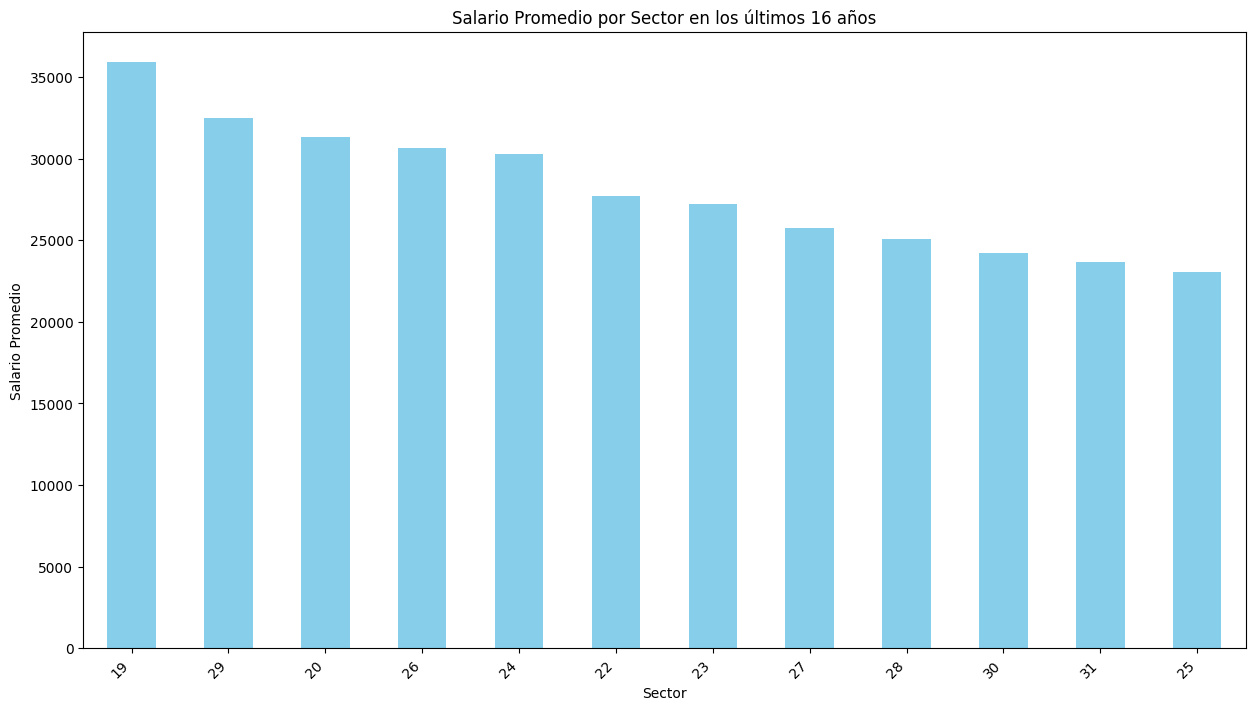

In [6]:
buscador()

# Con la palabra clave "Fabricación" podemos ver que la Fabricación de productos de refinación de petróleo
# tiene un salario promedio considerablemente mayor que cualquier otra clase de producto fabricado


### Comparador de salario mensual en cada sector por salario mínimo vital y móvil mensual:

Compara el **SMVM** con el **Sueldo Promedio de todos los sectores disponibles** del año y mes ingresados por el usuario. 

In [7]:
# Primero creamos un dataframe con los datos del dataset de Salario Mínimo Vital Móvil
dfSalarioMinimo = pd.read_csv("indice-salario-minimo-vital-movil-pesos-corrientes.csv")
# Modificamos los nombres de las columnas para hacerlos más manejables
dfSalarioMinimo.rename(columns={
        'indice_tiempo': 'Fecha',
        'salario_minimo_vital_movil_mensual': 'SMVM mensual',
        'salario_minimo_vital_movil_diario' : 'SMVM diario',
        'salario_minimo_vital_movil_hora' : 'SMVM hora'},
        inplace=True
    )

# Filtramos el DataFrame para eliminar las filas anteriores al año 2007,
# ya que nuestro dfSalarios solo cuenta con datos desde el 2007 y más adelante los fusionaremos
dfSalarioMinimo['Fecha'] = pd.to_datetime(dfSalarioMinimo['Fecha'])
dfSalarioMinimo = dfSalarioMinimo[dfSalarioMinimo['Fecha'].dt.year >= 2007]

# Previsualización del DataFrame resultante
print("Salario mínimo vital móvil en pesos corrientes:")

dfSalarioMinimo

Salario mínimo vital móvil en pesos corrientes:


,Fecha,SMVM mensual,SMVM diario,SMVM hora
504,2007-01-01,800.0,32.0,4.0
505,2007-02-01,800.0,32.0,4.0
506,2007-03-01,800.0,32.0,4.0
507,2007-04-01,800.0,32.0,4.0
508,2007-05-01,800.0,32.0,4.0
...,...,...,...,...
703,2023-08-01,112500.0,4500.0,562.5
704,2023-09-01,118000.0,4720.0,590.0
705,2023-10-01,132000.0,5280.0,660.0
706,2023-11-01,146000.0,5840.0,730.0


In [8]:
# Luego creamos las funciones que nos permitirán hacer una búsqueda, una comparación y emitir el gráfico

def comparar_svmv_sueldo(df_sueldos, df_svmv, anio, mes):
    df_sueldos['Fecha'] = pd.to_datetime(df_sueldos['Fecha'])
    # Filtramos por año y mes
    df_sueldos_filtered = df_sueldos[(df_sueldos['Fecha'].dt.year == anio) & (df_sueldos['Fecha'].dt.month == mes)]
    df_svmv_filtered = df_svmv[(df_svmv['Fecha'].dt.year == anio) & (df_svmv['Fecha'].dt.month == mes)]

    # Agregamos columnas de año y mes a ambos DataFrames
    df_sueldos_filtered['Año'] = df_sueldos_filtered['Fecha'].dt.year
    df_sueldos_filtered['Mes'] = df_sueldos_filtered['Fecha'].dt.month

    df_svmv_filtered['Año'] = df_svmv_filtered['Fecha'].dt.year
    df_svmv_filtered['Mes'] = df_svmv_filtered['Fecha'].dt.month

    # Calculamos el Sueldo Promedio mensual por sector
    sueldo_promedio_mensual = df_sueldos_filtered.groupby(['Año', 'Mes', 'Sector'])['Sueldo Promedio'].mean().reset_index()

    # Comparamos el Sueldo Promedio mensual con el SVMV mensual
    resultado_comparacion = pd.merge(sueldo_promedio_mensual, df_svmv_filtered, on=['Año', 'Mes'], how='left')
    resultado_comparacion.drop(['SMVM diario', 'SMVM hora'], axis=1, inplace=True)
    return resultado_comparacion

def grafico_comparativo_sueldo_svmv(df_comparacion, anio, mes):
    # Filtramos por año y mes
    df_comparacion_filtered = df_comparacion[(df_comparacion['Año'] == anio) & (df_comparacion['Mes'] == mes)]
    # Filtramos el Sector 999: Otros porque dificulta la lectura del gráfico
    df_comparacion_filtered = df_comparacion_filtered[df_comparacion_filtered['Sector'] != 999]
    # Configuramos el gráfico con un ancho razonable para una lectura eficaz
    plt.figure(figsize=(20, 10))
    plt.bar(df_comparacion_filtered['Sector'], df_comparacion_filtered['Sueldo Promedio'], label='Sueldo Promedio', color='teal')
    plt.plot(df_comparacion_filtered['Sector'], df_comparacion_filtered['SMVM mensual'], marker='o', linestyle='-', color='orange', label='SMVM mensual')

    # Añadimos texto al gráfico
    plt.xticks(df_comparacion_filtered['Sector'], df_comparacion_filtered['Sector'])
    plt.xlabel('Sector')
    plt.ylabel('Monto')
    plt.title(f'Comparación de Sueldo Promedio y SMVM mensual - {anio}/{mes}')
    plt.legend()
    
    plt.show()

    return(df_comparacion_filtered.loc[0,'SMVM mensual'])

def buscadorSMVM():
    anio_clave = int(input("Ingrese el año de búsqueda:"))
    mes_clave = int(input("Ingrese el mes:"))
    resultado_comparacion = comparar_svmv_sueldo(dfSalarios, dfSalarioMinimo, anio_clave, mes_clave)

    # A partir de los datos buscados, imprimimos un gráfico
    return grafico_comparativo_sueldo_svmv(resultado_comparacion, anio_clave, mes_clave)

    

Sabiendo que las actividades involucradas con el petróleo y la minería son las mejores remuneradas de manera exponencial en relación al resto, veremos, al comparar su sueldo promedio con el salario mínimo vital móvil que pueden llegar a cuadriplicar (o más) el salario mínimo. Mientras, el resto de los salarios (o la mayoría de ellos) como mucho lo duplicarán y siempre habrá uno o más por debajo de la mínima, siendo los sectores vinculados al arte y el entretenimiento aquellos más desfavorecidos.

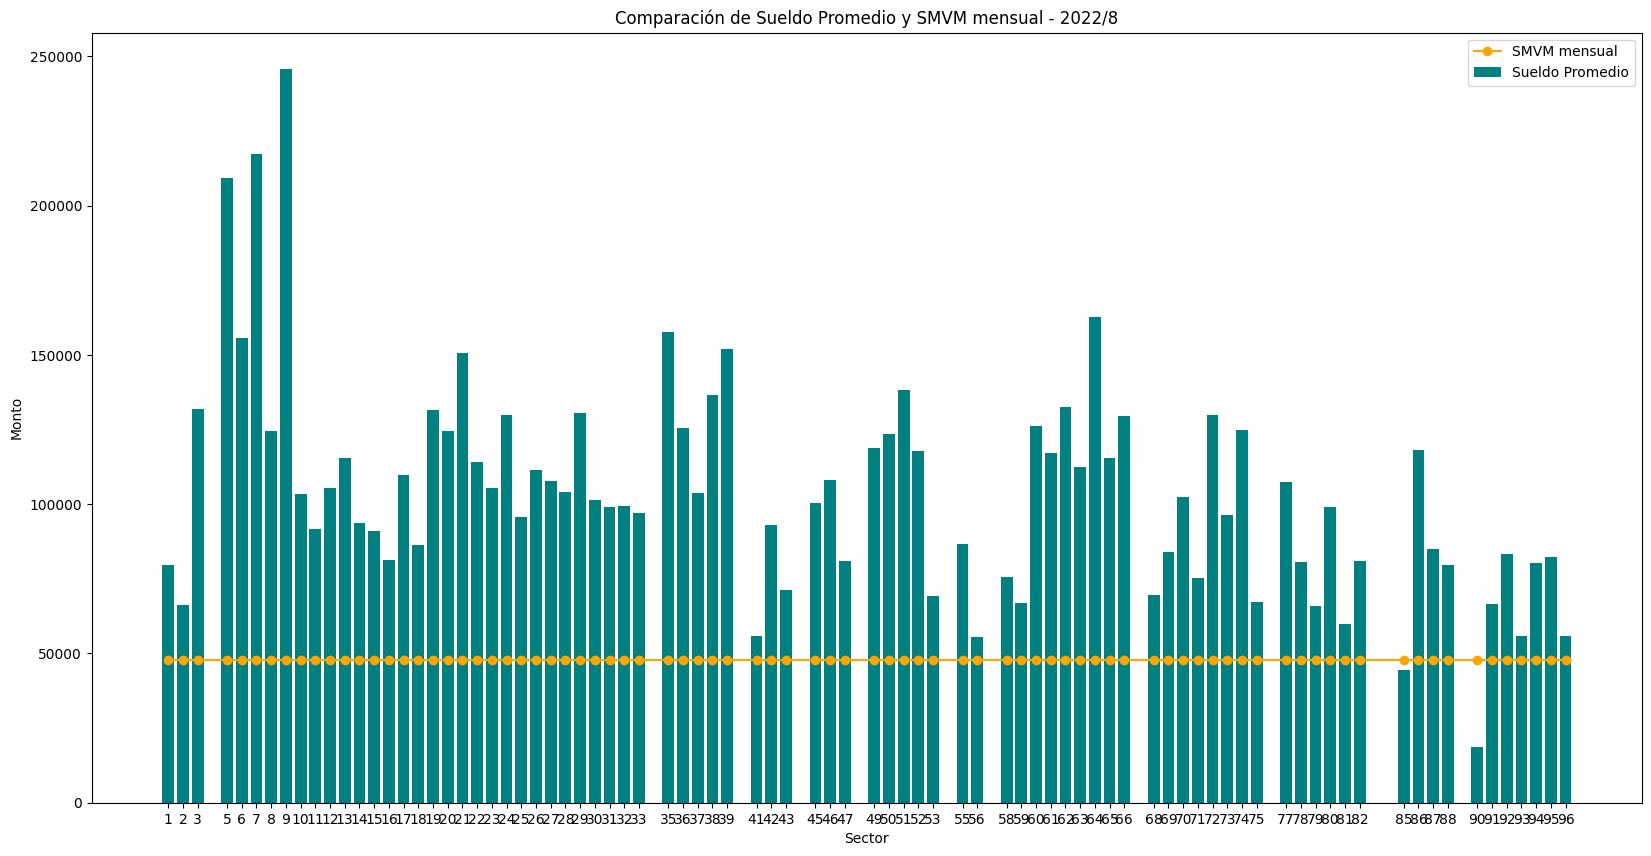

Valor del SMVM:  47850.0


In [9]:
print("Valor del SMVM: ",buscadorSMVM())



# Si buscamos marzo del 2009, por ejemplo, podemos ver que los tres sueldos promedios más altos son:

# 9: Actividades de apoyo al petróleo y la minería, 6: Extracción de petróleo crudo y gas natural y 51: Transporte Aéreo,
# en ese orden, seguidos por 7: Extracción de minerales metálicos, 35: Suministro de electricidad, gas, vapor y aire acondicionado
# y 60: Programación y transmisiones de TV y radio. Es decir que las dos actividades mejores remuneradas están dedicadas al petróleo
# y entre las 6 mejor remuneradas, 3 están vinculadas a la extracción y 3 a la producción de energía.
# En cuanto a aquellos que están por debajo del salario mínimo, de menor a mayor nos encontramos con:
# 90: Servicios artísticos y de espectáculos, 85: Enseñanza, 56: Servicios de expendio de alimentos y bebidas,
# 88: Actividades de atención sin alojamiento, 96: Otros servicios personales y 75: Servicios veterinarios.


### Función de apoyo para consultar el Sector

In [10]:
# Función que devuelve el nombre del sector basado en su número, para facilitar la lectura del gráfico anterior
def buscar_sector(_sector):
    print(_sector, ":", sectores_descripcion[_sector])

sector_a_buscar = int(input("Número del sector que desea buscar en el diccionario:"))
buscar_sector(sector_a_buscar)

90 : Servicios artísticos y de espectáculos


## Conversor a dólar

Muestra el tipo de cambio mensual histórico desde el 2007.

In [11]:
# Construimos una función para generar un promedio por mes de cada año de la conversión del dólar oficial y dólar blue
def calcular_tasa_promedio_mensual(csv_file, _encoding):
    # Columnas que deseamos leer (en este caso, las dos primeras); son las que necesitamos y las demás generan conflictos en su lectura
    columns_to_read = ['Fecha', 'Último']

    # Cargamos el CSV utilizando solo las columnas especificadas
    dfDolar = pd.read_csv(csv_file, sep=',', encoding=_encoding, usecols=columns_to_read)

    # Convertimos la 'Fecha' a tipo datetime
    dfDolar['Fecha'] = pd.to_datetime(dfDolar['Fecha'], dayfirst=True)
        
    # Convertimos 'Último' a tipo numérico, ignorando los errores
    dfDolar['Último'] = pd.to_numeric(dfDolar['Último'], errors='coerce')
        
    # Por si acaso, eliminamos filas con valores no numéricos
    dfDolar = dfDolar.dropna(subset=['Último'])
        
    # Creamos columnas adicionales para año y mes
    dfDolar['Año'] = dfDolar['Fecha'].dt.year
    dfDolar['Mes'] = dfDolar['Fecha'].dt.month

    # Modificamos el nombre de la columna 'Último'
    dfDolar = dfDolar.rename(columns={'Último': 'Conversión promedio'})

    # Calculamos el promedio mensual de conversión
    promedio_mensual = dfDolar.groupby(['Año', 'Mes'])['Conversión promedio'].mean().reset_index()
    
    return promedio_mensual # Lo devolvemos

# Dólar blue
promedioBlue = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')
print("Dólar Blue:\n")
promedioBlue



Dólar Blue:



,Año,Mes,Conversión promedio
0,2007,1,3.104783
1,2007,2,3.115500
2,2007,3,3.119091
3,2007,4,3.117619
4,2007,5,3.113478
...,...,...,...
198,2023,7,517.710526
199,2023,8,669.318182
200,2023,9,735.750000
201,2023,10,907.875000


In [12]:
def salario_a_dolar(_df):
    # Nos aseguramos de que Fecha sea un tipo de dato de tiempo
    _df['Fecha'] = pd.to_datetime(_df['Fecha'], dayfirst=True)
    # Creamos una columna adicional para Año y para Mes
    _df['Mes'] = _df['Fecha'].dt.month
    _df['Año'] = _df['Fecha'].dt.year
    # Unimos los dataframes por Año y Mes
    _df = pd.merge(_df, promedioBlue, on=['Año', 'Mes'], how='left')
    # Calculamos el equivalente del salario en dólares blue
    _df['Salario en dólar blue'] = _df['Sueldo Promedio'] / _df['Conversión promedio']

    # Eliminamos la columna 'Fecha' y 'Conversión promedio'
    _df = _df.drop(['Fecha', 'Conversión promedio'], axis=1)

    # Mostramos el DataFrame resultante
    return _df

salarios_dolar_blue = salario_a_dolar(dfSalarios)
print("Salario en dólar Blue:\n")
salarios_dolar_blue 

Salario en dólar Blue:



,Sector,Sueldo Promedio,Mes,Año,Salario en dólar blue
0,999,687,1,2007,221.271531
1,1,800,1,2007,257.666993
2,2,736,1,2007,237.053634
3,3,1473,1,2007,474.429352
4,5,999,1,2007,321.761658
...,...,...,...,...,...
16910,92,193317,7,2023,373.407513
16911,93,116402,7,2023,224.839933
16912,94,176101,7,2023,340.153408
16913,95,134212,7,2023,259.241397


De aquí en más, utiliaremos este dataframe (*salarios_dolar_blue*) con los salarios y su valor en dólares.

## Comparador de salarios históricos por sector

Se ingresan dos sectores para la comparacion de su **salario histórico anual** en Pesos Argentinos y Dólares.

También se puede consultar solo un sector específico ingresando un 0 en el segundo campo.

- Si comparamos los sectores 9: Actividades de apoyo al petróleo y la minería y 90: Servicios artísticos y de espectáculos, veremos que la diferencia entre ambos es abismal, y probablemente la más extrema de las diferencias que podremos encontrar entre todos los sectores.

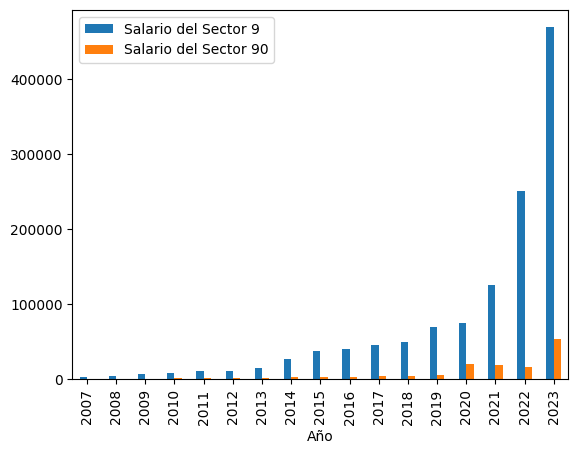

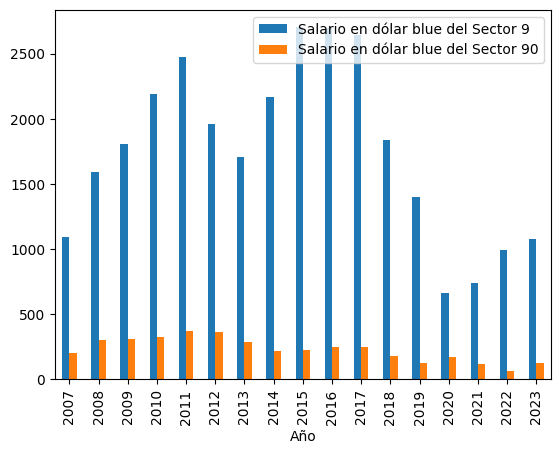

,Sector,Salario del Sector 9,Salario del Sector 90,Salario en dólar blue del Sector 9,Salario en dólar blue del Sector 90
Año,,,,,
2007,9.0,3438.916667,639.000000,1092.383878,203.394896
2008,9.0,5135.333333,963.583333,1595.894655,302.012388
2009,9.0,6834.666667,1183.166667,1809.055752,314.055014
2010,9.0,8729.333333,1307.583333,2193.820435,328.686389
2011,9.0,10760.250000,1625.416667,2472.503206,374.187349
2012,9.0,11202.500000,2061.083333,1961.332440,363.164430
2013,9.0,15047.916667,2484.333333,1711.331852,288.221201
2014,9.0,27026.083333,2686.416667,2169.552935,220.750245
2015,9.0,37600.250000,3218.166667,2701.963781,227.665594


In [13]:
# Creamos una función que busca el sector de trabajo y emite una tabla con el sueldo promedio anual de dicho sector
# y genera un gráfico de barras que muestra la evolución en el tiempo
def salario_por_anio(sector, sector2):

    # Filtramos por el sector seleccionado los datos de cada año
    dfSalariosFiltrado = salarios_dolar_blue.loc[salarios_dolar_blue['Sector'] == sector]

    renombrePesos = 'Salario del Sector ' + str(sector)
    renombreDolarB = 'Salario en dólar blue del Sector ' + str(sector)
    dfSalariosFiltrado = dfSalariosFiltrado.rename(columns={'Sueldo Promedio': renombrePesos,
                                                                'Salario en dólar blue': renombreDolarB})

    # Agrupamos por año y calculamos el promedio de sueldo entre todos los meses
    anio = dfSalariosFiltrado['Año']
    dfSalariosFiltrado = dfSalariosFiltrado.groupby(anio).mean()

    # Agregamos columna secundaria
    if sector2 != 0:
        df2 = salarios_dolar_blue.loc[salarios_dolar_blue['Sector'] == sector2]

        renombreDolarB2 = 'Salario en dólar blue del Sector ' + str(sector2)
        renombrePesos2 = 'Salario del Sector ' + str(sector2)
        df2 = df2.rename(columns={'Sueldo Promedio': renombrePesos2, 'Salario en dólar blue': renombreDolarB2})

        anio = df2['Año']
        df2 = df2.groupby(anio).mean()

        df2Salarios = df2[[renombrePesos2, renombreDolarB2]]

        dfSalariosFiltrado = dfSalariosFiltrado.join(df2Salarios)

        dfSalariosFiltrado = dfSalariosFiltrado[['Sector',renombrePesos,renombrePesos2,renombreDolarB,renombreDolarB2]]

        dfSalariosFiltrado[[renombrePesos, renombrePesos2]].plot.bar(legend=True)
        plt.show()

        dfSalariosFiltrado[[renombreDolarB, renombreDolarB2]].plot.bar(legend=True)
        plt.show()
    else:
        dfSalariosFiltrado[[renombrePesos]].plot.bar(legend=True)
        plt.show()

        dfSalariosFiltrado[[renombreDolarB]].plot.bar(legend=True)
        plt.show()



    display(dfSalariosFiltrado.head(20))

# Interfaz para que el usuario ingrese el sector de trabajo
sector = int(input("Ingresar el Sector de trabajo como figura en su valor numérico:"))
sector2 = int(input("Ingresar un segundo Sector de Actividad como figura en su valor numérico (0 para no agregar ninguno):"))
salario_por_anio(sector, sector2)

In [14]:
# Se facilita nuevamente el buscador de sectores del diccionario para asegurar lo que se está comparando
sector_a_buscar = int(input("Número del sector que desea buscar en el diccionario:"))
buscar_sector(sector_a_buscar)

9 : Actividades de apoyo al petróleo y la minería


# Predicciones
## Regresión polinomial
Esta regresión muestra la evolución del salario de un sector específico en el tiempo y ofrece luego la predicción de su valor en un año cercano del futuro

In [15]:
def grafico_regresion_polinomial(df, sector, anio_futuro):
    # Filtramos el DataFrame por el sector proporcionado
    df_sector = df[df['Sector'] == sector]

    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X = df_sector[['Año']]
    y_sueldo = df_sector['Sueldo Promedio']
    X_train_sueldo, X_test_sueldo, y_train_sueldo, y_test_sueldo = train_test_split(X, y_sueldo, test_size=0.2, random_state=42)

    y_dolar_blue = df_sector['Salario en dólar blue']
    X_train_dolar_blue, X_test_dolar_blue, y_train_dolar_blue, y_test_dolar_blue = train_test_split(X, y_dolar_blue, test_size=0.2, random_state=42)

    # Gráfico de regresión polinomial para Sueldo Promedio por año
    plot_regresion_polinomial(X_train_sueldo, y_train_sueldo, X_test_sueldo, y_test_sueldo, 'Año', 'Sueldo Promedio', sector, anio_futuro)

    # Gráfico de regresión polinomial para Salario en dólar blue por año
    plot_regresion_polinomial(X_train_dolar_blue, y_train_dolar_blue, X_test_dolar_blue, y_test_dolar_blue, 'Año', 'Salario en dólar blue', sector, anio_futuro)

def plot_regresion_polinomial(X_train, y_train, X_test, y_test, x_label, y_label, sector, anio_futuro):
    # Ajustamos el modelo de regresión polinomial al grado 4 (con una curva más representativa de los datos que se ven)
    model = make_pipeline(PolynomialFeatures(4), LinearRegression())
    model.fit(X_train, y_train)

    # Predecimos valores para la línea de regresión en el conjunto de entrenamiento y prueba
    X_pred_train = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
    y_pred_train = model.predict(X_pred_train)

    X_pred_test = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)
    y_pred_test = model.predict(X_pred_test)

    # Graficamos los datos de entrenamiento y prueba, la línea de regresión y la proyección a futuro
    plt.scatter(X_train, y_train, label='Datos de entrenamiento', color='blue')
    plt.scatter(X_test, y_test, label='Datos de prueba', color='green')
    plt.plot(X_pred_train, y_pred_train, label='Regresión polinomial grado 4 (entrenamiento)', color='red')
    plt.plot(X_pred_test, y_pred_test, label='Regresión polinomial grado 4 (prueba)', color='orange')

    # Proyección a futuro (3 años más)
    X_future = np.arange(X_test.max().iloc[0], X_test.max().iloc[0] + 3, 1).reshape(-1, 1)
    y_future = model.predict(X_future)
    plt.plot(X_future, y_future, label='Proyección a futuro', linestyle='dashed', color='purple')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Regresión Polinomial {y_label} por {x_label} - Sector: {sector}')

    # Calculamos la predicción en el año futuro aportado por el usuario
    X_future_user = np.array([[anio_futuro]])
    y_future_user = model.predict(X_future_user)
    plt.scatter(X_future_user, y_future_user, label=f'Predicción para {anio_futuro}', color='black', marker='x')
    print(f'El valor predicho para {y_label} en el {anio_futuro} es: {y_future_user[0]}')

    # Evaluamos el rendimiento del modelo
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f'\nEvaluación del rendimiento:')
    print(f'MSE en conjunto de entrenamiento: {mse_train:.2f}')
    print(f'MSE en conjunto de prueba: {mse_test:.2f}')
    print(f'R² en conjunto de entrenamiento: {r2_train:.2f}')
    print(f'R² en conjunto de prueba: {r2_test:.2f}')

    plt.legend()
    plt.show()

Dado lo analizado anteriormente y que las diferencias son cada vez más grandes entre cada sector, veremos que en la predicción a futuro, el salario joven del sector 9: Actividades de apoyo al petróleo y la minería será 9 veces el del sector 90: Servicios artísticos y de espectáculos. En ambos casos apreciaremos, además, que mientras el salario en pesos aumenta, su valor en dólares tiende a disminuir.

El valor predicho para Sueldo Promedio en el 2024 es: 516521.2470703125

Evaluación del rendimiento:
MSE en conjunto de entrenamiento: 1968726652.40
MSE en conjunto de prueba: 896031114.87
R² en conjunto de entrenamiento: 0.83
R² en conjunto de prueba: 0.88


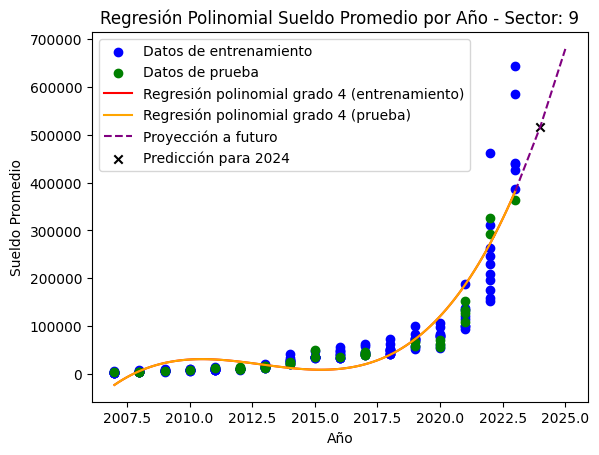

El valor predicho para Salario en dólar blue en el 2024 es: 424.9743003845215

Evaluación del rendimiento:
MSE en conjunto de entrenamiento: 232696.62
MSE en conjunto de prueba: 277382.38
R² en conjunto de entrenamiento: 0.56
R² en conjunto de prueba: 0.47


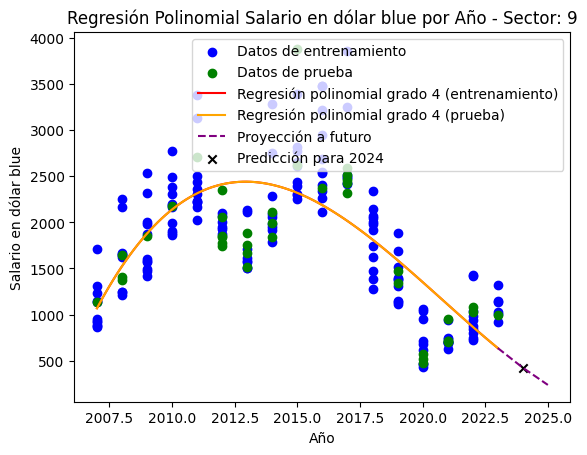

In [16]:
grafico_regresion_polinomial(salarios_dolar_blue, 9, 2024)

El valor predicho para Sueldo Promedio en el 2024 es: 53573.76171875

Evaluación del rendimiento:
MSE en conjunto de entrenamiento: 51947546.70
MSE en conjunto de prueba: 25890529.06
R² en conjunto de entrenamiento: 0.67
R² en conjunto de prueba: 0.77


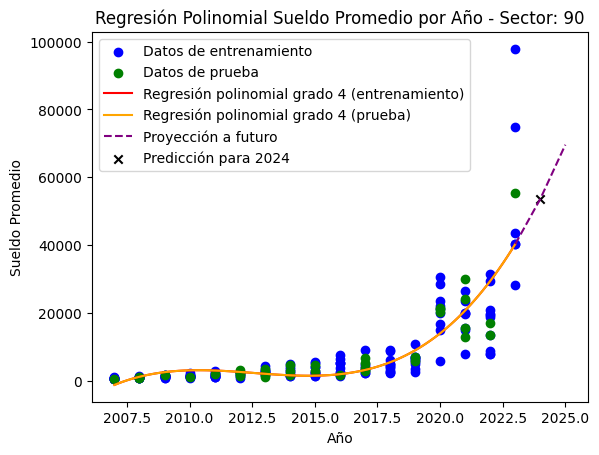

El valor predicho para Salario en dólar blue en el 2024 es: 123.19685184955597

Evaluación del rendimiento:
MSE en conjunto de entrenamiento: 9172.40
MSE en conjunto de prueba: 8525.02
R² en conjunto de entrenamiento: 0.42
R² en conjunto de prueba: 0.44


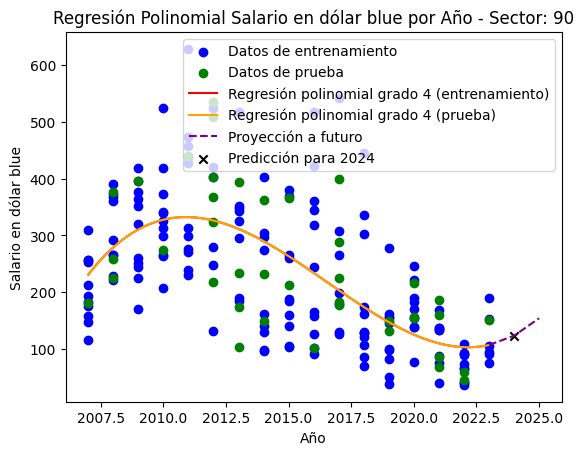

In [17]:
grafico_regresion_polinomial(salarios_dolar_blue, 90, 2024)

# EXTRAS

## Calculador de Peso Argentino a Dolar Blue

Transforma un monto determinado en **Pesos Argentinos** al **Dólar Blue**, dado un determinado año y mes

In [18]:
def convertir_a_dolaresB(monto, año, mes, tasa_promedio_mensual):
    # Se filtra el DataFrame para obtener la tasa de cambio correspondiente al año y mes especificados
    filtro = (tasa_promedio_mensual['Año'] == año) & (tasa_promedio_mensual['Mes'] == mes)

    if filtro.any():  # Se verifica si hay al menos una fila después de aplicar el filtro
        tasa_cambio = tasa_promedio_mensual.loc[filtro, 'Conversión promedio'].values[0]
        # Se realiza la conversión
        monto_en_dolares = monto / tasa_cambio
        return monto_en_dolares
    else:
        print(f"No hay datos disponibles para el año {año} y mes {mes}.")
        return None
    
def convertidor_peso_dolar():

    tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')

    monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
    año_conversion = int(input("El año en el que se desea calcular la conversión:"))
    mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

    monto_dolaresB = convertir_a_dolaresB(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
    if monto_dolaresB is not None:
        print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolaresB:.2f} dólares americanos blue el 15/{mes_conversion}/{año_conversion}.')
    else:
        print("No se pudo realizar la conversión. Verifica los datos disponibles.")

convertidor_peso_dolar()



1000000 pesos argentinos eran aproximadamente 3442.61 dólares americanos blue el 15/8/2022.
